In [1]:
# https://www.physionet.org/content/sleep-edfx/1.0.0/
import pandas as pd
import numpy as np
np.random.seed(10)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import platform
if platform.system() == "Windows":
    plt.rcParams['font.family'] = ['SimHei'] # Windows
elif platform.system() == "Darwin":
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # MacOS
plt.rcParams['axes.unicode_minus']=False 


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
records = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal']

In [3]:
import os
from tqdm import tqdm
def load_data(folder_path):
    X_data = []
    y_data = []
    categories = os.listdir(folder_path)
    for category in tqdm(sorted(categories)):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for file_name in sorted(os.listdir(category_path)):
                if file_name.endswith('.npy'):
                    file_path = os.path.join(category_path, file_name)
                    X = np.load(file_path)
                    X_data.append(X)
                    y_data.append(category)
    X_data = np.asarray(X_data)
    y_data = np.asarray(y_data)
    return X_data[y_data!='4'], y_data[y_data!='4']


train_folder = "/kaggle/input/eeg-signal-sleep-stage1/modified archive/EEG_Sample/train"
val_folder = "/kaggle/input/eeg-signal-sleep-stage1/modified archive/EEG_Sample/val"
test_folder = "/kaggle/input/eeg-signal-sleep-stage1/modified archive/EEG_Sample/test"

X_traindata, y_traindata = load_data(train_folder)
X_testdata, y_testdata = load_data(test_folder)
X_valdata, y_valdata = load_data(val_folder)

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


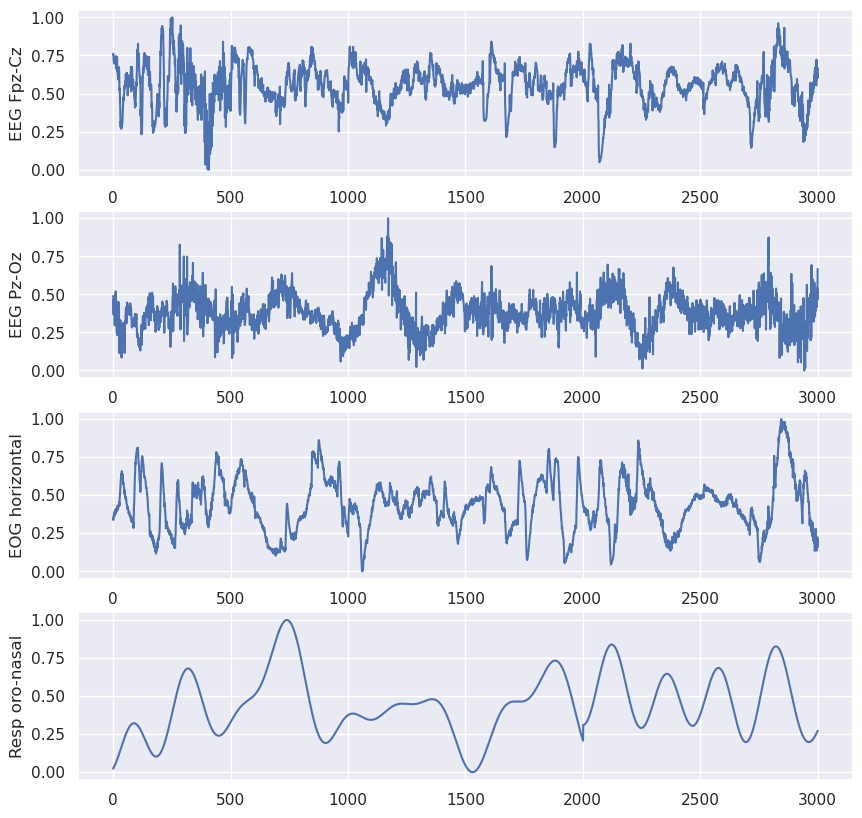

In [4]:
x = X_traindata[-1]
fig = plt.figure(figsize=(10,10))
for i in range(len(records)):
    ax = fig.add_subplot(4,1,i+1)
    ax.plot(x[i],label=records[i])
    ax.set_ylabel(records[i])
plt.show()

In [5]:
X_train = np.asarray(X_traindata)
X_val = np.asarray(X_valdata)
X_test = np.asarray(X_testdata)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_traindata).reshape(-1,1)).toarray()
y_val = encoder.transform(np.array(y_valdata).reshape(-1,1)).toarray()
y_test = encoder.transform(np.array(y_testdata).reshape(-1,1)).toarray()

X_train = X_train.reshape(X_train.shape[0],X_train.shape[2],X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0],X_val.shape[2],X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[2],X_test.shape[1])

X = np.concatenate([X_train,X_val,X_test],axis=0)
y = np.concatenate([y_train,y_val,y_test],axis=0)

In [6]:
np.save("X_sleep_signal.npg",X)
np.save("y_sleep_signal.npg",y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=50,shuffle=True)

In [8]:
### Attention Layer

import os
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer


debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))
class Attention(object if debug_flag else Layer):

    def __init__(self, units=128, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            self.attention_score_vec = Dense(input_dim, use_bias=False, name='attention_score_vec')
            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')
            self.attention_score = Dot(axes=[1, 2], name='attention_score')
            self.attention_weight = Activation('softmax', name='attention_weight')
            self.context_vector = Dot(axes=[1, 1], name='context_vector')
            self.attention_output = Concatenate(name='attention_output')
            self.attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: felixhao28, philipperemy.
        """
        if debug_flag:
            self.build(inputs.shape)
        
        score_first_part = self.attention_score_vec(inputs)

        h_t = self.h_t(inputs)
        score = self.attention_score([h_t, score_first_part])
        attention_weights = self.attention_weight(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.context_vector([inputs, attention_weights])
        pre_activation = self.attention_output([context_vector, h_t])
        attention_vector = self.attention_vector(pre_activation)
        return attention_vector

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'units': self.units})
        return config
    

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM,Bidirectional,Conv1D,MaxPooling1D,AveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def evaluation_classification(y_test,y_pred):
    metrics = {}
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score   
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    metrics['cls_report'] = classification_report(y_test, y_pred)
    metrics['accuracy'] = accuracy_score(y_test,y_pred)
    metrics['precision'] =  precision_score(y_test,y_pred,average='macro')
    metrics['recall'] = recall_score(y_test,y_pred,average='macro')
    metrics['f1-score'] = f1_score(y_test,y_pred,average='macro')
    return metrics
def plot_Confusion_Matrix(model=None,X_test=None,y_test=None,y_pred=None,label_names = None, show_percent = True,file_prefix=None):
    """
   
    Params
    - model 
    """
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8,7))
    ax1 = fig.add_subplot(1,1,1)
    if model==None:
        res = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,ax=ax1,values_format='.2%' if show_percent else '.0f',
                                                    cmap='YlGnBu',normalize='true' if show_percent else None,# pred or true
                                                    display_labels=label_names)
    else:
        res = ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,ax=ax1,values_format='.2%' if show_percent else '.0f',
                                                    cmap='YlGnBu',normalize='true' if show_percent else None,
                                                    display_labels=label_names)
    if model!=None:
        plt.title(f"{type(model).__name__} - Confusion Matrix")
    else:
        ax1.set_title("Confusion Matrix")
    plt.grid(False)
    plt.savefig(f"{file_prefix} - " if file_prefix else ''+(f"{type(model).__name__} - " if model!=None else '') + 'Comfusion Matrix' +'.jpg',dpi=400)
    plt.show()


from keras.callbacks import ReduceLROnPlateau

def train_model(model, model_name='Model', epochs=5):
    model_show = plot_model(model, to_file=model_name+'.jpg', show_shapes=True, show_layer_names=True)
    
    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1)
    
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        batch_size=128,
                        callbacks=[reduce_lr])  # Add the callback here
    
    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    metrics = evaluation_classification(y_true, y_pred)
    plot_Confusion_Matrix(model=None, X_test=None, y_test=y_true, y_pred=y_pred, label_names=None, show_percent=False, file_prefix=model_name)
    
    return model, metrics, history, model_show

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1500, 64)          832       
                                                                 
 average_pooling1d (AverageP  (None, 1500, 64)         0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 749, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 749, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 374, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 374, 64)          0

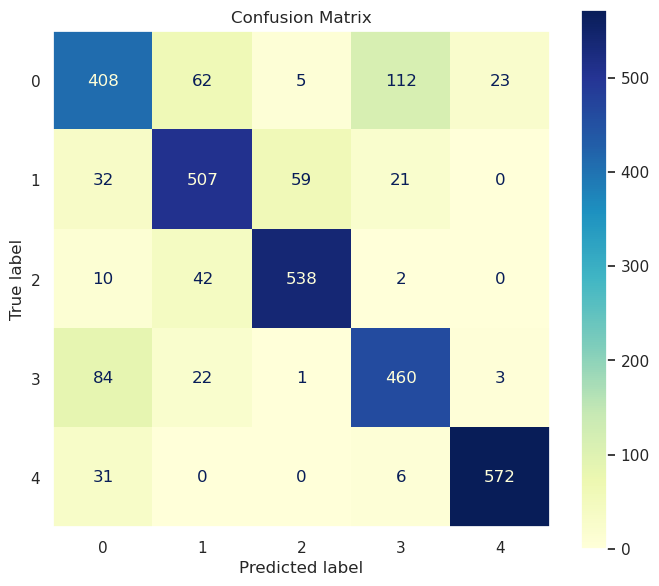

{'cls_report': '              precision    recall  f1-score   support\n\n           0       0.72      0.67      0.69       610\n           1       0.80      0.82      0.81       619\n           2       0.89      0.91      0.90       592\n           3       0.77      0.81      0.79       570\n           4       0.96      0.94      0.95       609\n\n    accuracy                           0.83      3000\n   macro avg       0.83      0.83      0.83      3000\nweighted avg       0.83      0.83      0.83      3000\n', 'accuracy': 0.8283333333333334, 'precision': 0.8274380307367318, 'recall': 0.8285922909777895, 'f1-score': 0.8276496820386617}


In [9]:
#### Create a model
# from tensorflow.python.keras import regularizers
def create_CNN_BiLSTM_Attention_model(units=64,activation='relu',optimizer='adam'):
    # instantiate the model
    model = Sequential()
    # cnn1d Layers
    model.add(Conv1D(units,3,2, input_shape=(X_train.shape[1], X_train.shape[2]), activation = activation))
    model.add(AveragePooling1D(pool_size=1))
    for i in range(4):
        model.add(Conv1D(units,3,2, activation =activation))
        model.add(MaxPooling1D(pool_size=1))
    model.add(Bidirectional(LSTM(units, activation = activation, return_sequences=True),merge_mode='concat'))
    model.add(Dropout(0.2))
    ## Attention
    model.add(Attention(units))
    model.add(Dense(128))
    model.add(Dense(y_train.shape[1],activation='softmax', name='Output'))        # can also specify linear activation function 
    # model compilation
    model.compile(optimizer='adam',  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_CNN_BiLSTM_Attention_model()
print(model.summary())
model,metrics,history,model_show = train_model(model,epochs=100)
print(metrics)

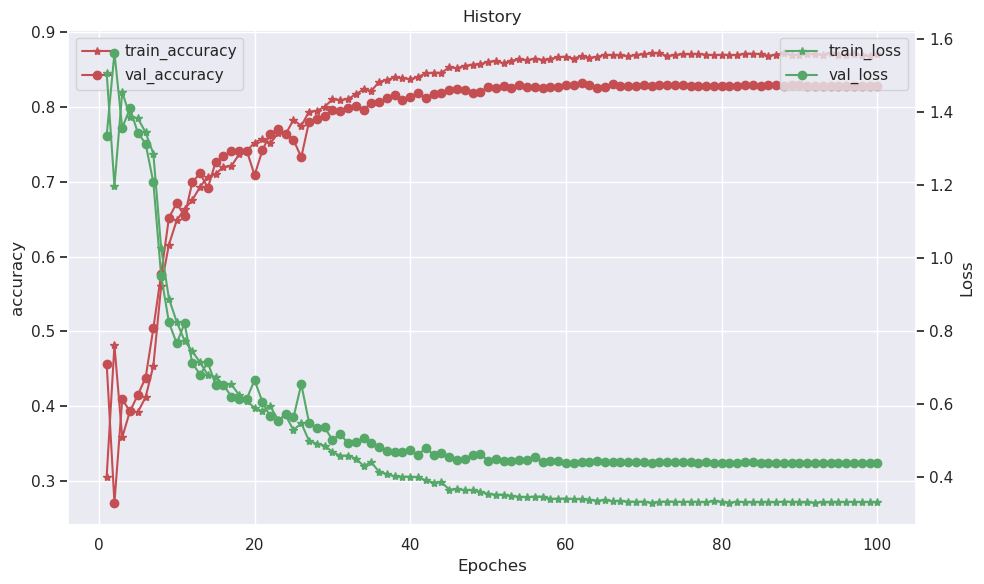

In [10]:
def plot_training_history(history,metric = 'accuracy'):
    """
    plot training history for keras/tensorflow/pytorch model
    history = model.fit(....)
    Plot the accuracy vs epoch, and loss vs epoch for training and validation data.
    """
    import matplotlib.pyplot as plt
    if type(history) is not dict:
        history = history.history
    assert type(history) is dict
    if 'train_loss' not in history.keys():
        history['train_loss'] = history['loss']
    if f'train_{metric}' not in history.keys():
        history[f'train_{metric}'] = history[metric]
    loss = history['train_loss']
    acc = history[f'train_{metric}']
    val_loss = history['val_loss']
    val_acc = history[f'val_{metric}']

    x_epoch = list(range(1,len(loss)+1))
    # plot the figure
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,1,1)
    ax2 = ax1.twinx()
    ax1.plot(x_epoch,acc,'r-*',label = f'train_{metric}')
    ax2.plot(x_epoch,loss,'g-*',label = 'train_loss')
    ax1.plot(x_epoch,val_acc,'r-o',label = f'val_{metric}')
    ax2.plot(x_epoch,val_loss,'g-o',label = 'val_loss')
    ax1.legend(loc = 2)
    ax2.legend(loc = 1)
    ax1.set_ylabel(metric)
    ax2.set_ylabel('Loss')
    ax1.set_xlabel('Epoches')
    plt.grid(False)
    plt.title("History")
    plt.tight_layout()
    plt.show()

plot_training_history(history,metric='accuracy')